# 규제가 있는 선형회귀 - 릿지, 라쏘, 엘라스틱넷 회귀

#### 규제가 있는 모델 구축 - 당뇨병 데이터세트
#### 1. 데이터 전처리
#### 2. Ridge, Lasso, Elasticnet regression 구축: 회귀 계수 확인, 하이퍼 파라미터 탐색
#### 3. 교차 검증으로 최적의 하이퍼파라미터 탐색: LassoCV()

In [1]:
# 관련 라이브러리 및 모듈 Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# 0. 데이터 수집, 탐색, 준비

In [3]:
from sklearn.datasets import load_diabetes

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

####  데이터셋에 대한 설명 및 정보 확인

In [4]:
# 데이터셋 정보확인
diab = load_diabetes()
diab.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

#### 데이터프레임 변환

In [5]:
# 독립변수(피처)와 종속변수를 DataFrame자료형으로 변환
# 데이터셋 객체의 data 배열, 즉, 독립변수 X가되는 피처(특성)들을 DataFrame자료형으로 변환하여
# diab_df생성
# diab_df.head() 데이터 5개 확인
diab_df = pd.DataFrame(data=diab.data, columns=diab.feature_names)
diab_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


In [6]:
# 누락치 확인,  data type 확인 ->  isnull().sum(), target에 결측값이 있으면 해당 관측치 제거
diab_df.isnull().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

In [7]:
diab_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


In [8]:
# X(독립변수), Y(종속변수) 분할
X = diab.data
y = diab.target

In [9]:
# 학습용, 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 모델별 계수변화, 알파별 계수 비교 데이터프레임(comp_df)

In [10]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index=diab.feature_names) # 인덱스만 생성됨
comp_df

""
age
sex
bmi
bp
s1
s2
s3
s4
s5
s6


In [11]:
#각 모델별 계수로 이루어진 데이터프레임 준비
comp_df = pd.DataFrame(index=diab.feature_names + ["R2 scores"]) # 추가하고 인덱스가 있다면
comp_df

""
age
sex
bmi
bp
s1
s2
s3
s4
s5
s6


In [12]:
#각 모델별, 규제강도별 평가지표 저장


# 1. 규제가 없는 선형모델

In [13]:
#모델 구축 및 학습
model_LR = LinearRegression()
model_LR.fit(X_train, y_train)
#모델 평가
y_pred = model_LR.predict(X_test)
from evaluate_model import evaluate_score

evaluate_score(y_test, y_pred)
# 회귀 계수 확인
LR_coef = pd.Series(model_LR.coef_, index=diab.feature_names)
print(LR_coef)
# r2
# print(r2)

age     29.254013
sex   -261.706469
bmi    546.299723
bp     388.398341
s1    -901.959668
s2     506.763241
s3     121.154351
s4     288.035267
s5     659.268951
s6      41.376701
dtype: float64


- 계수값 시각화

<BarContainer object of 10 artists>

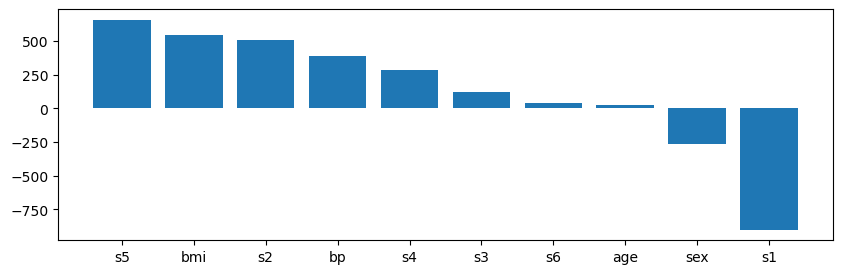

In [14]:
coef = LR_coef.sort_values(ascending=False)
# 시각화 
plt.figure(figsize=(10, 3))
plt.bar(coef.index, coef)

#### 절대값으로 처리해서 어떤게 가장 큰 영향을 끼치는지 확인

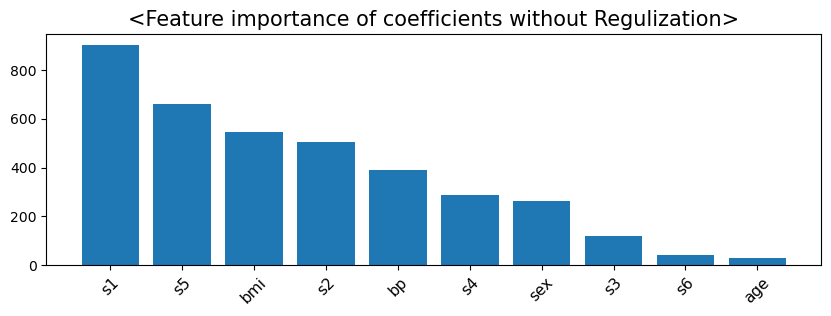

In [15]:
coef = LR_coef.sort_values(ascending=False)
# print(coef)
coef = np.abs(LR_coef).sort_values(ascending=False)
# print('====')
# print(coef)
# 시각화 
plt.figure(figsize=(10, 3))
plt.title("<Feature importance of coefficients without Regulization>", fontsize=15)
plt.bar(coef.index, coef)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [16]:
# 모델별 비교 데이터프레임 열 추가
r2 = 0.477
comp_df['LR'] = np.append(model_LR.coef_, r2)
comp_df

,LR
age,29.254013
sex,-261.706469
bmi,546.299723
bp,388.398341
s1,-901.959668
s2,506.763241
s3,121.154351
s4,288.035267
s5,659.268951
s6,41.376701


# 2. 릿지 모델

In [17]:
from sklearn.linear_model import Ridge
model_RG = Ridge(alpha=1)
model_RG.fit(X_train, y_train)

Ridge(alpha=1)

In [18]:
# 릿지 선형회귀 모델 평가: model_Ridge1, alpha=1
y_pred = model_RG.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
# a=1일때 회귀 계수 확인
coef= model_RG.coef_
coef

0.4233440269603016


array([  45.05421022,  -71.94739737,  280.71625182,  195.21266175,
         -2.22930269,  -17.54079744, -148.68886188,  120.46723979,
        198.61440137,  106.93469215])

In [19]:
# 선형 모델 평가


#a = 1 릿지 모델 회귀 계수


- 계수값 시각화

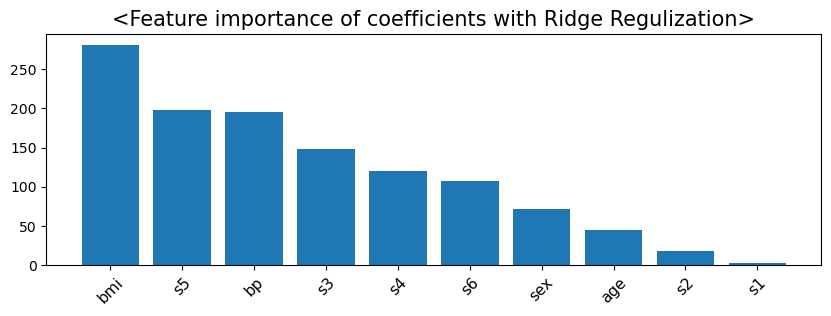

In [20]:
coef = pd.Series(np.abs(model_RG.coef_), index=diab.feature_names)
coef = coef.sort_values(ascending=False)
# 시각화
plt.figure(figsize=(10, 3))
plt.title("<Feature importance of coefficients with Ridge Regulization>", fontsize=15)
plt.bar(coef.index, coef)
plt.xticks(coef.index, rotation=45, fontsize=11); # 규제를 줬더니 회귀계수가 미치는 영향이 작아졌다

In [21]:
# alpha_list=[0.01, 1, 10, 100]인 경우

alpha_list=[0.01, 1, 10, 100]
for each in alpha_list:
    model_RG = Ridge(alpha=each)
    model_RG.fit(X_train, y_train)
    y_pred = model_RG.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'Ridge(alpha={each:.2f})'
    comp_df[col_name] = np.append(model_RG.coef_, r2)

In [22]:
comp_df # alpha가 커질수록, 규제가 커질 수록 회귀계수와 결정계수의 변화를 확인하는 데이터 

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00)
age,29.254013,34.167328,45.054210,16.230889,2.072848
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808
bmi,546.299723,550.844882,280.716252,59.524160,6.899915
bp,388.398341,379.126708,195.212662,43.421300,5.085100
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660
s2,506.763241,123.029219,-17.540797,10.865267,1.743748
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876
s4,288.035267,215.032624,120.467240,38.728538,4.902421
s5,659.268951,463.842634,198.614401,49.224746,5.926496
s6,41.376701,50.351490,106.934692,34.737987,4.328698


# 2. 라쏘 모델

In [23]:
from sklearn.linear_model import Lasso
# alpha = 1, default
model_Lasso = Lasso(alpha=1)
model_Lasso.fit(X_train, y_train)

Lasso(alpha=1)

In [24]:
# 라쏘 선형회귀 모델 평가(alpha=1)
# 선형 모델 평가
y_pred = model_Lasso.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)
# a = 1 라쏘 모델 회귀 계수

Lasso_coef = pd.Series(model_Lasso.coef_, index=diab.feature_names)
Lasso_coef

0.36189802861957876


age      0.000000
sex     -0.000000
bmi    443.703388
bp      51.601094
s1       0.000000
s2       0.000000
s3      -0.000000
s4       0.000000
s5     201.966478
s6       0.000000
dtype: float64

- 계수 시각화

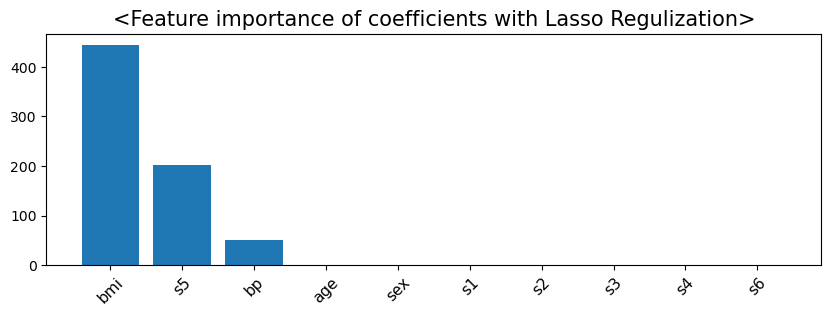

In [25]:
coef = np.abs(Lasso_coef)
coef = pd.Series(coef, index=diab.feature_names).sort_values(ascending=False)
# 시각화
plt.figure(figsize=(10, 3))
plt.title("<Feature importance of coefficients with Lasso Regulization>", fontsize=15)
plt.bar(coef.index, coef)
plt.xticks(coef.index, rotation=45, fontsize=11);

In [26]:
# alpha_list=[0.01, 1, 10, 100]인 경우
alpha_list=[0.01, 1, 10, 100]
for each in alpha_list:
    model_Lasso = Lasso(alpha=each)
    model_Lasso.fit(X_train, y_train)
    y_pred = model_Lasso.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'Lasso(alpha={each:.2f})'
    comp_df[col_name] = np.append(model_Lasso.coef_, r2)

In [27]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00),Lasso(alpha=0.01),Lasso(alpha=1.00),Lasso(alpha=10.00),Lasso(alpha=100.00)
age,29.254013,34.167328,45.054210,16.230889,2.072848,28.246364,0.000000,0.000000,0.000000
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808,-250.819184,-0.000000,0.000000,0.000000
bmi,546.299723,550.844882,280.716252,59.524160,6.899915,556.215874,443.703388,0.000000,0.000000
bp,388.398341,379.126708,195.212662,43.421300,5.085100,380.659502,51.601094,0.000000,0.000000
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660,-468.739540,0.000000,0.000000,0.000000
s2,506.763241,123.029219,-17.540797,10.865267,1.743748,166.993417,0.000000,0.000000,0.000000
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876,-60.219459,-0.000000,-0.000000,-0.000000
s4,288.035267,215.032624,120.467240,38.728538,4.902421,230.916253,0.000000,0.000000,0.000000
s5,659.268951,463.842634,198.614401,49.224746,5.926496,492.634358,201.966478,0.000000,0.000000
s6,41.376701,50.351490,106.934692,34.737987,4.328698,43.969346,0.000000,0.000000,0.000000


# 3. 엘라스틱넷 모델

In [28]:
from sklearn.linear_model import ElasticNet

# 모델 구축 및 학습(alpha=1, l1_ratio=0.5)
model_ElasticNet = ElasticNet(alpha=0.1, l1_ratio=0.5)
model_ElasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.1)

In [29]:
#모델 평가 및 회귀 계수 확인
# 엘라스틱넷 선형회귀 모델 평가(alpha=1, L1_ratio=0.5)
# 선형 모델 평가
y_pred = model_ElasticNet.predict(X_test)
r2 = r2_score(y_test, y_pred)

#a = 1 엘라스틱넷 모델 회귀 계수
coef = pd.Series(model_ElasticNet.coef_, index=diab.feature_names)

print("R2:{:.3f} \n".format(r2))
print(coef)

R2:0.104 

age    10.591712
sex    -0.285015
bmi    39.807218
bp     28.892278
s1      9.604595
s2      7.589472
s3    -25.067309
s4     26.506264
s5     33.260185
s6     23.526244
dtype: float64


In [30]:
alpha_list=[0.01, 1, 10, 100]
for each in alpha_list:
    model_ElasticNet = ElasticNet(alpha=each)
    model_ElasticNet.fit(X_train, y_train)
    y_pred = model_ElasticNet.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    col_name = f'ElasticNet(alpha={each:.2f})'
    comp_df[col_name] = np.append(model_ElasticNet.coef_, r2)

In [31]:
comp_df

,LR,Ridge(alpha=0.01),Ridge(alpha=1.00),Ridge(alpha=10.00),Ridge(alpha=100.00),Lasso(alpha=0.01),Lasso(alpha=1.00),Lasso(alpha=10.00),Lasso(alpha=100.00),ElasticNet(alpha=0.01),ElasticNet(alpha=1.00),ElasticNet(alpha=10.00),ElasticNet(alpha=100.00)
age,29.254013,34.167328,45.054210,16.230889,2.072848,28.246364,0.000000,0.000000,0.000000,41.417999,0.367567,0.000000,0.000000
sex,-261.706469,-254.043316,-71.947397,-2.961367,-0.003808,-250.819184,-0.000000,0.000000,0.000000,-45.935016,0.000000,0.000000,0.000000
bmi,546.299723,550.844882,280.716252,59.524160,6.899915,556.215874,443.703388,0.000000,0.000000,225.053463,3.512046,0.000000,0.000000
bp,388.398341,379.126708,195.212662,43.421300,5.085100,380.659502,51.601094,0.000000,0.000000,158.163233,2.328646,0.000000,0.000000
s1,-901.959668,-404.253263,-2.229303,13.875073,2.069660,-468.739540,0.000000,0.000000,0.000000,9.021067,0.380194,0.000000,0.000000
s2,506.763241,123.029219,-17.540797,10.865267,1.743748,166.993417,0.000000,0.000000,0.000000,-1.762029,0.168337,0.000000,0.000000
s3,121.154351,-99.041674,-148.688862,-37.495847,-4.508876,-60.219459,-0.000000,-0.000000,-0.000000,-124.240022,-1.955958,-0.000000,-0.000000
s4,288.035267,215.032624,120.467240,38.728538,4.902421,230.916253,0.000000,0.000000,0.000000,106.910117,2.228128,0.000000,0.000000
s5,659.268951,463.842634,198.614401,49.224746,5.926496,492.634358,201.966478,0.000000,0.000000,165.006085,2.887428,0.000000,0.000000
s6,41.376701,50.351490,106.934692,34.737987,4.328698,43.969346,0.000000,0.000000,0.000000,97.213477,1.846225,0.000000,0.000000


- 계수 시각화

In [32]:


# 시각화


In [33]:
# alpha_list=[0.01, 1, 10, 100]인 경우, l1_ratio=0.5 



### LassoCV() : k-폴드 교차 검증으로 최적의 Lasso 모델 하이퍼파라미터 alpha 찾기

In [34]:
#LassoCV()에 필요한 매개변수 설정
#0.01 ~ 9.91 까지 alpha_list  생성
cv = 5
alpha_list = np.arange(0.01, 10, 0.01)
max_iter = 1000

In [35]:
from sklearn.linear_model import LassoCV

model_LassoCV = LassoCV(alphas=alpha_list, cv=5, max_iter=1000, n_jobs=-1, random_state=42)

- 모델 학습

In [36]:
model_LassoCV.fit(X_train, y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99]),
        cv=5, n_jobs=-1, random_state=42)

In [37]:
model_LassoCV.alpha_

0.01

In [38]:
y_pred = model_LassoCV.predict(X_test)
r2_score(y_test, y_pred)

0.47871428812904404

## GridSearchCV

In [39]:
from sklearn.model_selection import GridSearchCV

model_ElasticNet = ElasticNet()
param_grid = {
    'alpha': [0.01, 1, 10, 100],
    'l1_ratio':[0.1, 0.3, 0.6, 0.9],
}
grid = GridSearchCV(model_ElasticNet, param_grid=param_grid, cv=3)

In [40]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': [0.01, 1, 10, 100],
                         'l1_ratio': [0.1, 0.3, 0.6, 0.9]})

In [41]:
y_pred = grid.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(r2)

0.47378958651114567


In [42]:
grid.best_params_

{'alpha': 0.01, 'l1_ratio': 0.9}

In [43]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'rank_test_score']]

,mean_test_score,rank_test_score
0,0.276728,4
1,0.308736,3
2,0.371355,2
3,0.454411,1
4,-0.028251,8
5,-0.027520,7
6,-0.024958,6
7,-0.007083,5
8,-0.034742,9
9,-0.035039,10


## [응용] 보스턴 주택가격 데이터를 활용하여, 규제가 없을때, 리지, 라쏘, 엘라스틱넷 선형회귀를 수행하고 각각의 회귀계수 및 예측 성능을 비교하라
테스트 사이즈:0.3
random_state=42


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from evaluate_model import evaluate_score
import evaluate_model
import pandas as pd
import numpy as np

boston = fetch_openml('boston')
X = boston.data.values
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model_LR = LinearRegression()
reg = model_LR.fit(X_train, y_train)
y_pred = reg.predict(X_test)

evaluate_score(y_test, y_pred)

comp_df = pd.DataFrame(index=boston.feature_names + ["R2 Scores"])

c:\Users\PlayData\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:292: UserWarning: Multiple active versions of the dataset matching the name boston exist. Versions may be fundamentally different, returning version 1.
  warn(
c:\Users\PlayData\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
LR_coef = pd.Series(model_LR.coef_, index=boston.feature_names)
LR_coef = np.abs(LR_coef).sort_values(ascending=False)
comp_df["LR"] = np.append(LR_coef, evaluate_model.r2)

In [ ]:
alpha_list = [i for i in np.arange(0.01, 100, 10)]
for alpha in alpha_list:
    model = Ridge()
    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    evaluate_score(y_test, y_pred)
    col_name = f"Ridge(alpha={alpha:.2f})"
    comp_df[col_name] = np.append(model.coef_, evaluate_model.r2)
for alpha in alpha_list:
    model = Lasso()
    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    evaluate_score(y_test, y_pred)
    col_name = f"Lasso(alpha={alpha:.2f})"
    comp_df[col_name] = np.append(model.coef_, evaluate_model.r2)
for alpha in alpha_list:
    model = ElasticNet(alpha=alpha, l1_ratio=0.5)
    reg = model.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    evaluate_score(y_test, y_pred)
    col_name = f"ElasticNet(alpha={alpha:.2f})"
    comp_df[col_name] = np.append(model.coef_, evaluate_model.r2)
print(comp_df)

                  LR  Ridge(alpha=0.01)  Ridge(alpha=10.01)  \
CRIM       15.417061          -0.128427           -0.128427   
ZN          4.057199           0.036952            0.036952   
INDUS       3.119835           0.017914            0.017914   
CHAS        1.385998           2.932695            2.932695   
NOX         0.910685          -7.848060           -7.848060   
RM          0.547113           4.063574            4.063574   
AGE         0.242727          -0.017242           -0.017242   
DIS         0.133470          -1.271761           -1.271761   
RAD         0.049523           0.225494            0.225494   
TAX         0.035809          -0.009381           -0.009381   
PTRATIO     0.011794          -0.827105           -0.827105   
B           0.010821           0.011988            0.011988   
LSTAT       0.008702          -0.563474           -0.563474   
R2 Scores   0.711226           0.704159            0.704159   

           Ridge(alpha=20.01)  Ridge(alpha=30.01)  Rid